In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation,RationalQuadratic, WhiteKernel
import random

/opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def generate_fake_data(xmin, xmax, n_samples=10, polynomial_degree=2, noise_level=1):
    x = [random.uniform(xmin, xmax) for _ in range(n_samples)]
    # Generate random noise of the same length as x
    noise = np.random.normal(scale=noise_level, size=n_samples)
    # Generate the y values according to a polynomial equation with some added noise
    y = np.polyval([random.uniform(0,10) for _ in range(polynomial_degree + 1)], x) + noise
    y = np.abs(y) # force y to be positive
    return np.array(x), np.array(y)

In [3]:
x,y = generate_fake_data(0, 10, 5, polynomial_degree=3, noise_level=5)

### Step 1: GP Fit

In [4]:
def GPR(X, Y, kernel= None):
    """
    Fit GP to demand
    run once per product

    :param X: X values with shape (-1, 1)
    :param Y: Y values with shape (-1, 1)
    :param kernel: kernel for the GP
    :return: GPR model
    """

    kernel = kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X, Y)
    return gaussian_process

model = GPR(x.reshape(-1,1),y.reshape(-1,1), kernel = 1 * RationalQuadratic(alpha= 10, length_scale=1000) + WhiteKernel(noise_level=10, noise_level_bounds=(1e-5, 1e2)))
print(model)

GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=10, length_scale=1e+03) + WhiteKernel(noise_level=10),
                         n_restarts_optimizer=10)


/opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### Test Step 1

In [5]:
### Plot model to check
Xplot = np.linspace(-0.1, 10.1, 100)
f_mean, f_var = model.predict(Xplot.reshape(-1,1), return_std=True)

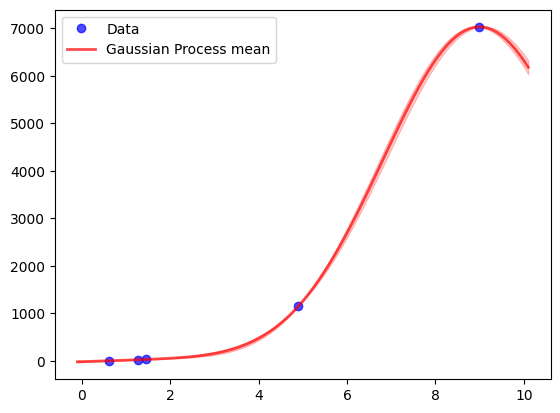

In [6]:
plt.plot(x, y, 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, f_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, f_mean - f_var, f_mean + f_var, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

### Step 2 : Sample demand from GP
We use 2 products here to make things simpler

In [7]:
%%capture
### kernel
kernel = 1 * RationalQuadratic(alpha= 1, length_scale=100, length_scale_bounds=(0.01, 1000)) +  WhiteKernel(noise_level=1000, noise_level_bounds=(1e-5, 1e2))
### generate datasets for both products
Ds = [generate_fake_data(0, 10, n_samples=5, polynomial_degree=3, noise_level=10) for _ in range(2)]
### generate GPs for both products
GPs = [GPR(Ds[i][0].reshape(-1,1), Ds[i][1].reshape(-1,1), kernel = kernel) for i in range(2)]

In [8]:
### Plot model to check
Xplot = np.linspace(-0.1, 10.1, 100)
mean0, std0 = GPs[0].predict(Xplot.reshape(-1,1), return_std=True)
mean1, std1 = GPs[1].predict(Xplot.reshape(-1,1), return_std=True)

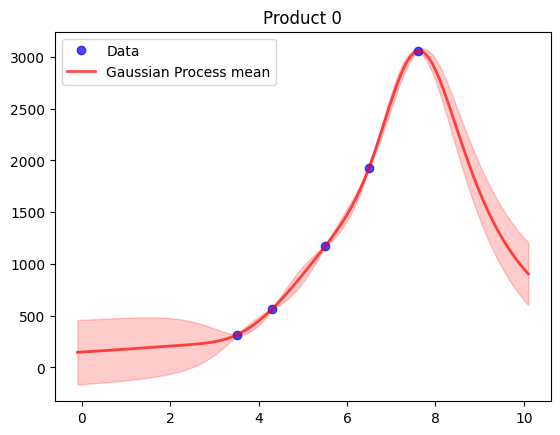

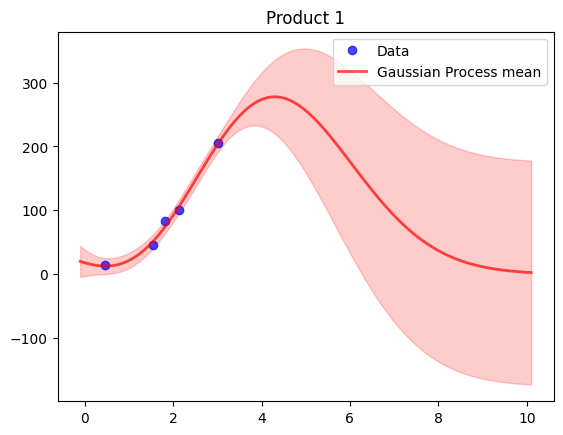

In [9]:
plt.figure()
plt.title('Product 0')
plt.plot(Ds[0][0], Ds[0][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean0, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean0 - std0, mean0 + std0, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

plt.figure()
plt.title('Product 1')
plt.plot(Ds[1][0], Ds[1][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean1, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean1 - std1, mean1 + std1, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

#### Sample for each price vector

In [10]:
### assume we only offer prices 1, 5, 7 --> get all possible price combinations
import itertools

def get_unique_permutations(lst, length):
    """
    Returns a list of all possible unique permutations of a given length of elements
    in a given list.
    """
    permutations = list(itertools.permutations(lst, length))
    unique_permutations = list(set(permutations))
    result = [list(x) for x in unique_permutations]
    same_val = [result.append([x]*2) for x in lst]
    return result

price_vectors = get_unique_permutations([6, 7, 8], length=2)
print(price_vectors)

[[8, 7], [6, 8], [6, 7], [7, 6], [8, 6], [7, 8], [6, 6], [7, 7], [8, 8]]


##### Check the posterior samples make sense

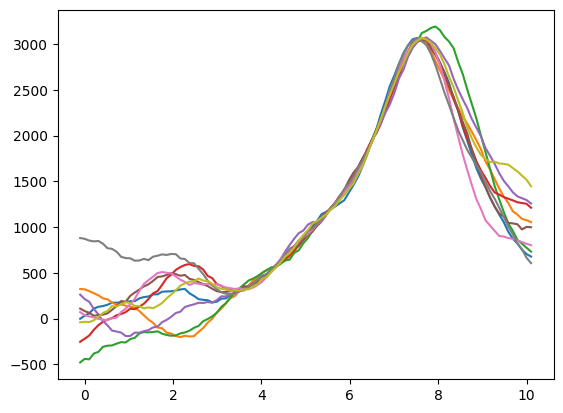

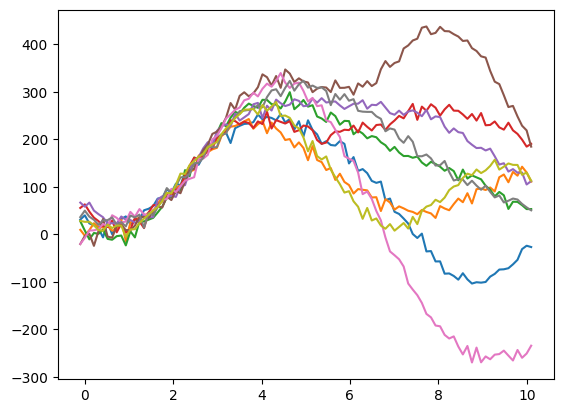

In [11]:
evaluated_y = []
for prod in range(2):
    # Generate samples from posterior distribution. One for each price vector
    y_hat_samples = GPs[prod].sample_y(Xplot.reshape(-1,1), n_samples=len(price_vectors), random_state=None) # no fixed behaviour!
    plt.plot(Xplot, y_hat_samples)
    # for each price vector evaluate demand using the correct GP sample. i.e for 0th element of each price vector, evaluate the GP[0] sample
    # for the 1st element of each price vector, evaluate GP[1] and so on
    evaluated_y.append([np.interp(price_vectors[i][prod], Xplot, y_hat_samples[:,i]) for i in range(len(price_vectors))])
    plt.show()
# combine indexes together to get back to price pairs [price_0, price_1]
evaluations = [list(i) for i in list(zip(*evaluated_y))]

In [12]:
evaluations, price_vectors

([[2836.9282818654997, 49.81789512661665],
  [1471.345636884435, 49.83292653508732],
  [1446.0625674182663, 183.20281089279564],
  [2513.1474733391638, 221.2579145421977],
  [2952.6984854345105, 270.4947013026046],
  [2582.170700481387, 431.766092977872],
  [1462.506757809711, 158.1817637835635],
  [2614.841375229507, 220.53961410214376],
  [2912.7605378467215, 69.63452147908318]],
 [[8, 7], [6, 8], [6, 7], [7, 6], [8, 6], [7, 8], [6, 6], [7, 7], [8, 8]])

### Step 3: Solve Linear Program
https://realpython.com/linear-programming-python/

In [13]:
from scipy.optimize import linprog

In [14]:
# define some max quantity of each product
max_inventory = [100000, 100000] # per product (unconstrained)
a = [[1,1] for _ in range(len(price_vectors))] # every time a sale happens we lose 1 product

# first get the coefficients for the linear program
result_for_lp = []
subject_to = []
for k in range(len(price_vectors)): # price vectors
    sub_k_result = []
    sub_subject_to = []
    for i in range(2): # products
        sub_k_result.append(price_vectors[k][i] * evaluations[k][i])
        sub_subject_to.append(a[k][i] * evaluations[k][i])
    subject_to.append(np.sum(sub_subject_to))
    result_for_lp.append(np.sum(sub_k_result))

subject_coeffs = [subject_to]*2 # one is needed per product as cj is different per product (potentially)

# xk inequality (sum of x <= 1)
xk_ineq = list(np.full(len(price_vectors),1))

# combine to make LHS inequalities
subject_coeffs.append(xk_ineq)

lhs_ineq = subject_coeffs # rename to be more clear
# Define RHS of the inequalities
max_inventory.append(1)

rhs_ineq = max_inventory

assert len(rhs_ineq) == len(lhs_ineq)
# xk >= 0 definition
bnd = [(0, 1) for _ in range(len(price_vectors))]

# objective 
result_for_lp = [x*-1 for x in result_for_lp] # maximise!!!

# print(lhs_ineq, "\n")
# print(rhs_ineq)
# print(bnd)
# print(result_for_lp)

opt = linprog(c=result_for_lp, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")

In [15]:
opt

     con: array([], dtype=float64)
     fun: -25244.556091291714
 message: 'Optimization terminated successfully.'
     nit: 1
   slack: array([96776.80681326, 96776.80681326,     0.        ])
  status: 0
 success: True
       x: array([0., 0., 0., 0., 1., 0., 0., 0., 0.])

### Random choice from x

In [16]:
choose_price_index = np.argwhere(opt['x'] == np.random.choice(opt['x'], p=opt['x']))[0][0]

In [17]:
price_vectors[choose_price_index]

[8, 6]

### Different LP method

In [18]:
from pulp import GLPK, LpProblem, LpMaximize, LpVariable, lpSum, LpStatus

In [27]:
max_inventory = [10000, 10000] # per product (unconstrained)
a = [[1,1] for _ in range(len(price_vectors))] # every time a sale happens we lose 1 product

# first get the coefficients for the linear program
result_for_lp = []
subject_to = []
for k in range(len(price_vectors)): # price vectors
    sub_k_result = []
    sub_subject_to = []
    for i in range(2): # products
        sub_k_result.append(price_vectors[k][i] * evaluations[k][i])
        sub_subject_to.append(a[k][i] * evaluations[k][i])
    subject_to.append(sub_subject_to)
    result_for_lp.append(np.sum(sub_k_result))

# result_for_lp_norm = (result_for_lp-np.min(result_for_lp))/(np.max(result_for_lp)-np.min(result_for_lp))
# Define the model
model = LpProblem(name="dynamic-pricing", sense=LpMaximize)

# manually set x values for now
x0 = LpVariable("x0", 0, 1, cat='Continuous')
x1 = LpVariable("x1", 0, 1, cat='Continuous') 
x2 = LpVariable("x2", 0, 1, cat='Continuous')
x3 = LpVariable("x3", 0, 1, cat='Continuous')
x4 = LpVariable("x4", 0, 1, cat='Continuous')
x5 = LpVariable("x5", 0, 1, cat='Continuous')
x6 = LpVariable("x6", 0, 1, cat='Continuous')
x7 = LpVariable("x7", 0, 1, cat='Continuous')
x8 = LpVariable("x8", 0, 1, cat='Continuous')

# Define the decision variables
# x = {i: LpVariable(name=f"x{i}", lowBound=0., upBound=1., cat='Continuous') for i in range(0, len(price_vectors))}

# print([result_for_lp[i]*x[i] for i in range(len(x))])

# Set the objective
model += result_for_lp[0] * x0 + result_for_lp[1] * x1 + result_for_lp[2] * x2 + result_for_lp[3] * x3 + \
result_for_lp[4] * x4 + result_for_lp[5] * x5 + result_for_lp[6] * x6 + result_for_lp[7] * x7 + result_for_lp[8] * x8

# model += lpSum([result_for_lp[i]*x[i] for i in range(len(x))])
# # # Add constraints
# model += (lpSum(x.values()) == 1, "xk_constraint")
model += x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 <= 1, "xk constraint"
model += subject_to[0][0] * x0 + subject_to[1][0] * x1 + subject_to[2][0] * x2 + subject_to[3][0] * x3 + \
subject_to[4][0] * x4 + subject_to[5][0] * x5 + subject_to[6][0] * x6 + subject_to[7][0] * x7 + subject_to[8][0] * x8 <= max_inventory[0], "product 0"
model += subject_to[0][1]* x0 + subject_to[1][1] * x1 + subject_to[2][1] * x2 + subject_to[3][1] * x3 + \
subject_to[4][1] * x4 + subject_to[5][1] * x5 + subject_to[6][1] * x6 + subject_to[7][1] * x7 + subject_to[8][1] * x8 <= max_inventory[0], "product 1"
model += x0 >= 0
model += x1 >= 0
model += x2 >= 0
model += x3 >= 0
model += x4 >= 0
model += x5 >= 0
model += x6 >= 0
model += x7 >= 0
model += x8 >= 0

# model += (lpSum([[x[0] for x in subject_to][i]*x[i] for i in range(len(x))]) <= max_inventory[0], "product_0")
# model += (lpSum([[x[1] for x in subject_to][i]*x[i] for i in range(len(x))]) <= max_inventory[1], "product_1")

# # model += (lpSum([subject_to[i]*x[i] for i in range(len(x))]) <= max_inventory[1], "product_1")
print(model)



# # # Solve the optimization problem
status = model.solve()

# Get the results
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

for v in model.variables():
    print(v.name, "=", v.varValue)
    
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

dynamic-pricing:
MAXIMIZE
23044.151520810316*x0 + 9226.73723358731*x1 + 9958.795080759166*x2 + 18919.579800627333*x3 + 25244.556091291714*x4 + 21529.323647192687*x5 + 9724.131129559646*x6 + 19847.666925321555*x7 + 23859.160474606437*x8 + 0.0
SUBJECT TO
xk_constraint: x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 <= 1

product_0: 2836.92828187 x0 + 1471.34563688 x1 + 1446.06256742 x2
 + 2513.14747334 x3 + 2952.69848543 x4 + 2582.17070048 x5 + 1462.50675781 x6
 + 2614.84137523 x7 + 2912.76053785 x8 <= 10000

product_1: 49.8178951266 x0 + 49.8329265351 x1 + 183.202810893 x2
 + 221.257914542 x3 + 270.494701303 x4 + 431.766092978 x5 + 158.181763784 x6
 + 220.539614102 x7 + 69.6345214791 x8 <= 10000

_C1: x0 >= 0

_C2: x1 >= 0

_C3: x2 >= 0

_C4: x3 >= 0

_C5: x4 >= 0

_C6: x5 >= 0

_C7: x6 >= 0

_C8: x7 >= 0

_C9: x8 >= 0

VARIABLES
x0 <= 1 Continuous
x1 <= 1 Continuous
x2 <= 1 Continuous
x3 <= 1 Continuous
x4 <= 1 Continuous
x5 <= 1 Continuous
x6 <= 1 Continuous
x7 <= 1 Continuous
x8 <= 1 Con

In [21]:
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

xk_constraint: 0.0
product_0: -7047.30151456549
product_1: -9729.505298697395
_C1: 0.0
_C2: 0.0
_C3: 0.0
_C4: 0.0
_C5: 1.0
_C6: 0.0
_C7: 0.0
_C8: 0.0
_C9: 0.0


In [22]:
x_vals_index = np.argmax([x.value() for x in x.values()])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [24]:
price_vectors[4]

[8, 6]

In [ ]:
subject_to

In [25]:
model.objective

23044.151520810316*x0 + 9226.73723358731*x1 + 9958.795080759166*x2 + 18919.579800627333*x3 + 25244.556091291714*x4 + 21529.323647192687*x5 + 9724.131129559646*x6 + 19847.666925321555*x7 + 23859.160474606437*x8 + 0.0

In [26]:
for v in model.variables():
    print(v.name, "=", v.varValue)

x0 = 0.0
x1 = 0.0
x2 = 0.0
x3 = 0.0
x4 = 1.0
x5 = 0.0
x6 = 0.0
x7 = 0.0
x8 = 0.0
